<a href="https://colab.research.google.com/github/MerkulovDaniil/split-sgd/blob/master/Code/Continuous_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression

In [0]:
# ======= Libraries =======

import math
import sys
import os
import time
os.environ["OMP_NUM_THREADS"] = "5" # export OMP_NUM_THREADS=5
os.environ["OPENBLAS_NUM_THREADS"] = "5" # export OPENBLAS_NUM_THREADS=5
os.environ["MKL_NUM_THREADS"] = "5" # export MKL_NUM_THREADS=5
os.environ["VECLIB_MAXIMUM_THREADS"] = "5" # export VECLIB_MAXIMUM_THREADS=5
os.environ["NUMEXPR_NUM_THREADS"] = "5" # export NUMEXPR_NUM_THREADS=5
import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint, solve_ivp
# from torchdiffeq import odeint
from scipy.linalg import expm, qr
import scipy.io as sio
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy
from tqdm import tqdm
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
device = torch.device('cpu')
import copy
from fastprogress.fastprogress import master_bar, progress_bar
import random
# Reproducibility
random.seed(999)
np.random.seed(999)
torch.manual_seed(999)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
# ======= Function definitions =======

def load_tom_data(epsilon=1e-5):
    X = sio.loadmat("./lls_data/fanlinear.mat")["A"].toarray()
    theta_true = sio.loadmat("./lls_data/shepplogan.mat")["x"]
    n, p = X.shape
    y = np.squeeze(X @ theta_true)
    return X, theta_true, y

def generate_problem(p, n, lstsq=False, epsilon = 0):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + epsilon*np.random.randn(n) # right-hand side
    init_bound = 1.0/math.sqrt(p)
    theta_0 = np.array(init_bound*torch.FloatTensor(p).uniform_(-1, 1))

    if lstsq == True:
        theta_lstsq = np.linalg.lstsq(X,y)[0]
        return X, theta_0, y, theta_lstsq
    else:
        return X, theta_0, y

def solve_local_problem(Q, R, theta_0, y_batch, h, n):
    try:
        R_it = np.linalg.inv(R.T)
    except np.linalg.LinAlgError as err:
        # print(err)
        R_it = np.linalg.pinv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return 1/n*np.linalg.norm(X @ theta - y)**2
    elif len(X.shape) == 3:
        s, b, p = Xs.shape
        n = b*s

        loss = 0
        for i_batch in range(s):
            loss += 1/n*np.linalg.norm(X[i_batch] @ theta - y[i_batch])**2
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')

def rel_residual(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return np.linalg.norm(X @ theta - y)/np.linalg.norm(y)
    elif len(X.shape) == 3:
        s, b, p = Xs.shape
        n = b*s

        loss = 0
        y_full = np.zeros(n)
        X_full = np.zeros((n, p))
        for i_batch in range(s):
            y_full[b*i_batch:b*(i_batch+1)]     = y[i_batch]
            X_full[b*i_batch:b*(i_batch+1), :]  = X[i_batch]

        return np.linalg.norm(X_full @ theta - y_full)/np.linalg.norm(y_full)
    else:
        raise ValueError('🤔 Inappropriate format of dataset')


def gradient(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return 1/n* X.T @ (X @ theta - y)
    elif len(X.shape) == 3:
        s, b, p = Xs.shape
        n = b*s

        gradient = 0
        for i_batch in range(s):
            gradient += 1/n* X[i_batch].T @ (X[i_batch] @ theta - y[i_batch])
        return gradient
    else:
        raise ValueError('🤔 Inappropriate format of dataset')

def make_SGD_step(X_batch, theta_0, y_batch, lr):
    theta = theta_0 - lr*gradient(X_batch, theta_0, y_batch)
    return theta

def sgd_training(theta_0, theta_lstsq, Xs, ys, lr, N_epochs = N_epochs):
    s, b, p = Xs.shape
    n = b*s
    loss_sgd, grad_sgd, par_diff_sgd = [], [], []
    theta_t = theta_0
    stop_word = False
    for i_epoch in range(N_epochs):
        loss_sgd.append(loss(Xs, theta_t, ys))
        grad_sgd.append(np.linalg.norm(gradient(Xs, theta_t, ys)))
        par_diff_sgd.append(np.linalg.norm(theta_t - theta_lstsq)/np.linalg.norm(theta_lstsq))
        for i_batch in range(b):          
            theta_t = make_SGD_step(Xs[i_batch], theta_t, ys[i_batch], lr)

        sys.stdout.write('\r'+f'🤖 SGD. Loss {loss_sgd[-1]:.3f}, Grad_norm {grad_sgd[-1]:.3f}, relpardiff {par_diff_sgd[-1]:.3f} after {i_epoch} epoch. Lr {lr}')

    print('\r'+f'🤖 SGD. Loss {loss_sgd[-1]:.3f}, Grad_norm {grad_sgd[-1]:.3f}, relpardiff {par_diff_sgd[-1]:.3f} after {i_epoch} epoch. Lr {lr}')    
    return loss_sgd, grad_sgd, par_diff_sgd

def spl_training(theta_0, theta_lstsq, Qs, Rs, Xs, ys, stepsize, N_spl_steps = N_spl_steps):
    s, b, p = Xs.shape
    n = b*s
    loss_spl, grad_spl, par_diff_spl = [], [], []
    theta_t = theta_0
    for i_step in range(N_spl_steps):         
        i_batch = i_step % s
        if i_batch == 0:
            loss_spl.append(loss(Xs, theta_t, ys))
            grad_spl.append(np.linalg.norm(gradient(Xs, theta_t, ys)))
            par_diff_spl.append(np.linalg.norm(theta_t - theta_lstsq)/np.linalg.norm(theta_lstsq))
            sys.stdout.write('\r'+f'🤖 Splitting I. Loss {loss_spl[-1]:.3f}, Grad_norm {grad_spl[-1]:.3f}, relpardiff {par_diff_spl[-1]:.3f} after {i_step} epoch. Stepsize {stepsize}')

        theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], stepsize, n)
    
    print('\r'+f'🤖 Splitting I. Loss {loss_spl[-1]:.3f}, Grad_norm {grad_spl[-1]:.3f}, relpardiff {par_diff_spl[-1]:.3f} after {i_step} steps. Stepsize {stepsize}')
    return loss_spl, grad_spl, par_diff_spl

def plot_continuous_time_lls(times, losses, grads, rel_diffs, labels, N_epochs, title = 'Linear least squares. Random'):
    colors = ['r', 'g']
    color_labels = ['^', 'o']
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (9,3))
    fig.suptitle(title)
    for time, loss, grad, rel_diff, label, col, col_lab in zip(times, losses, grads, rel_diffs, labels, colors, color_labels):
        ax1.semilogy(time, loss,     col+col_lab, label = label)
        ax1.semilogy(time, loss,     col+':')
        ax2.semilogy(time, grad,     col+col_lab, label = label)
        ax2.semilogy(time, grad,     col+':')
        ax3.semilogy(time, rel_diff, col+col_lab, label = label)
        ax3.semilogy(time, rel_diff, col+':')
    ax1.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax1.set_title(r'$f(\theta(t))$')
    ax1.set_xlabel('t')
    ax2.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax2.set_title(r'$\|\nabla f(\theta(t))\|$')
    ax2.set_xlabel('t')
    ax3.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax3.set_title(r'$\frac{\|\theta(t) - \theta_{LS}\|}{\|\theta_{LS}\|}$')
    ax3.set_xlabel('t')
    plt.legend()
    fig.tight_layout()
    # plt.savefig(title + '.pdf')
    plt.show()

In [141]:
# ======= Problem generation =======

# We fix best learning rate for the SGD and try different hs for the splitting. 
# Drawing 3 graphs in cont time (loss, grad_norm, norm of theparameter difference)

p = 500
n = 1000
s = 50
b = 20
epsilon = 1e-1

LEARNING_RATE = 10**(-1.5)
N_epochs = 20
h = 1

N_spl_steps  = int(N_epochs*LEARNING_RATE*n/h)
N_spl_epochs = int(np.floor(N_epochs*LEARNING_RATE*b/h))

LABELS = ['SGD', 'Splitting I']
ts_sgd = np.linspace(0, N_epochs*LEARNING_RATE*b, int(N_epochs))
ts_spl = np.linspace(0, N_spl_epochs*h, N_spl_epochs+1)
# ts_spl = np.linspace(0, N_epochs*LEARNING_RATE*b, N_spl_epochs)

# problems = ['tomography', 'random']
# problems = ['tomography']
problems = ['random']

X, theta_0, y, theta_lstsq = generate_problem(p, n, lstsq=True, epsilon = epsilon)
Xs = np.zeros((s, b, p))
ys = np.zeros((s, b))
Qs = np.zeros((s, p, b))
Rs = np.zeros((s, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(s):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

loss_sgd, grad_sgd, par_diff_sgd = sgd_training(theta_0, theta_lstsq, Xs, ys, lr = LEARNING_RATE, N_epochs = N_epochs)
loss_spl, grad_spl, par_diff_spl = spl_training(theta_0, theta_lstsq, Qs, Rs, Xs, ys, stepsize = h, N_spl_steps = N_spl_steps)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


🤖 SGD. Loss 68.615, Grad_norm 8.504, relpardiff 0.496 after 19 epoch. Lr 0.03162277660168379
🤖 Splitting I. Loss 0.404, Grad_norm 0.333, relpardiff 0.074 after 631 steps. Stepsize 1


In [129]:
ts_spl

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ])

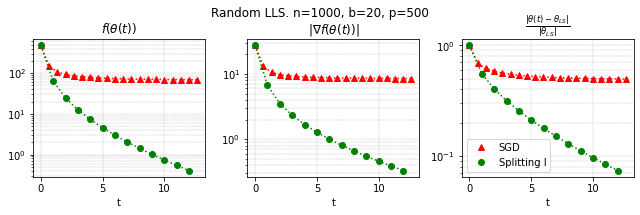

In [142]:
times     = [ts_sgd, ts_spl]
losses    = [loss_sgd, loss_spl]
grads     = [grad_sgd, grad_spl]
rel_diffs = [par_diff_sgd, par_diff_spl]
labels    = ['SGD', 'Splitting I']
title     = f'Random LLS. n={n}, b={b}, p={p}'
plot_continuous_time_lls(times, losses, grads, rel_diffs, labels, N_epochs, title)